In [1]:
# pip install tweepy

In [104]:
import pandas as pd
import numpy as np
import requests
import os

In [3]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
foldername = 'image_pred'
if not os.path.exists(foldername):
    os.makedirs(foldername)

In [5]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(foldername, url.split('/')[-1]), 'wb') as file:
    file.write(response.content)

In [6]:
image_predictions = pd.read_csv('image_pred/image-predictions.tsv', sep='\t')

In [7]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [8]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [9]:
tweet_ids = twitter_archive.tweet_id.values
print('list of twitter ids: ', tweet_ids , '\nsize of list : ', len(tweet_ids))

list of twitter ids:  [892420643555336193 892177421306343426 891815181378084864 ...
 666033412701032449 666029285002620928 666020888022790149] 
size of list :  2356


In [10]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [11]:
date = []
tweet_id = []
favorite_count = []
retweet_count = []
#Reading tweet_json.txt to Dataframe
with open('tweet-json.txt','r') as tweets:
    for tweet in tweets:
        tweet_js = json.loads(tweet)
        date.append(tweet_js['created_at'])
        tweet_id.append(tweet_js['id'])
        favorite_count.append(tweet_js['favorite_count'])
        retweet_count.append(tweet_js['retweet_count'])
#merging all columns to a dataframe.
df_json = pd.DataFrame({'Date': date,'tweet_id': tweet_id,'favorite_count': favorite_count,'retweet_count': retweet_count})

In [12]:
df_json.head()

,Date,tweet_id,favorite_count,retweet_count
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,39467,8853
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,33819,6514
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,25461,4328
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,42908,8964
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,41048,9774


# Assess

In [13]:
# Make a copy of all dataframes
tweets = twitter_archive.copy()
imgs_copy = image_predictions.copy()
json_tweets = df_json.copy()

In [14]:

tweets.shape

(2356, 17)

In [15]:
tweets.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
928,754747087846248448,NaN,NaN,2016-07-17 18:38:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Keith. He's pursuing a more 2D lifesty...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754747087...,12,10,Keith,None,None,None,None
192,855818117272018944,NaN,NaN,2017-04-22 16:18:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I HEARD HE TIED HIS OWN BOWTIE MARK AND HE JUS...,NaN,NaN,NaN,https://twitter.com/markhalperin/status/855656...,13,10,None,None,None,None,None
2202,668643542311546881,NaN,NaN,2015-11-23 04:13:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Fascinating dog here. Loves beach. Oddly long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668643542...,3,10,None,None,None,None,None


In [16]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
tweets.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
tweets.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [19]:
tweets.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [20]:
tweets.duplicated().sum()

0

In [21]:
tweets.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [22]:
tweets.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/667152164079423490/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/718631497683582976/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1                                                                    2
https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_r

In [23]:
tweets.expanded_urls.duplicated().sum()

137

In [24]:

imgs_copy.shape

(2075, 12)

In [25]:
imgs_copy.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1031,711363825979756544,https://pbs.twimg.com/media/Cd9Fn5QUMAAYMT4.jpg,1,Pembroke,0.750906,True,Cardigan,0.241152,True,basenji,0.002640,True
1941,861005113778896900,https://pbs.twimg.com/media/C_LnlF5VoAEsL1K.jpg,1,German_shepherd,0.507951,True,Pembroke,0.136113,True,muzzle,0.075764,False
814,692568918515392513,https://pbs.twimg.com/media/CZx_wV2UMAArgsJ.jpg,2,golden_retriever,0.636845,True,Labrador_retriever,0.163362,True,Pekinese,0.045554,True
1452,776813020089548800,https://pbs.twimg.com/media/CsfLUDbXEAAu0VF.jpg,1,toy_poodle,0.516610,True,miniature_poodle,0.255033,True,standard_poodle,0.168989,True
373,672988786805112832,https://pbs.twimg.com/media/CVbvjKqW4AA_CuD.jpg,1,Lakeland_terrier,0.836632,True,West_Highland_white_terrier,0.073900,True,wire-haired_fox_terrier,0.038160,True


In [26]:
imgs_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
imgs_copy.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
imgs_copy.duplicated().sum()

0

In [29]:
imgs_copy.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [30]:

json_tweets.shape

(2354, 4)

In [31]:
json_tweets.sample(3)

,Date,tweet_id,favorite_count,retweet_count
816,Tue Aug 30 22:04:05 +0000 2016,770743923962707968,0,52360
855,Fri Aug 12 04:35:10 +0000 2016,763956972077010945,812,61
757,Wed Sep 21 01:39:11 +0000 2016,778408200802557953,15135,5023


In [32]:
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            2354 non-null   object
 1   tweet_id        2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
 3   retweet_count   2354 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [33]:
json_tweets.describe()

,tweet_id,favorite_count,retweet_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [34]:
json_tweets.duplicated().sum()

0

In [35]:
json_tweets.isnull().sum()

Date              0
tweet_id          0
favorite_count    0
retweet_count     0
dtype: int64

## Quality Issues

1. Source column in twitter_archive has hyperlinks
2. Twitter_archive name column having 'a' as dog names
3. Twitter_archive expanded_urls column contains repetitive urls
4. Twitter_archive timestamp column is of wrong datatype
5. Twitter_archive has some retweets
6. P1,P2, P3 columns in image_predictions have underscore in the names
7. Tweet_id column is of integer datatype instead of string
8. Tweet_archive ratings denominator above 10
9. Rename p1 column to dog_breed
10. Remove rows from imgs_copy dataframe that arent dog breeds

## Tidiness Issues
1. Json date column is not tidy, needs to be cleaned
2. Dog_stages column created from four dog stages column in tweets dataframe
3. Dropping unnecessary columns
4. All three dataframes needs to be combined into one. 

## Clean

## Issue 1

### Define: Source column in tweets_no_RT has hyperlinks
Source column contains hyperlinks. <br>
These were handled by creating a new_source column containing only the links to the actual sources. 

### Code

In [36]:
tweets.source.head()

0    <a href="http://twitter.com/download/iphone" r...
1    <a href="http://twitter.com/download/iphone" r...
2    <a href="http://twitter.com/download/iphone" r...
3    <a href="http://twitter.com/download/iphone" r...
4    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

In [37]:
tweets['new_source'] = tweets.source.str.extract('((http://)([a-zA-Z.\w//\s]+))')[0]

In [38]:
tweets.new_source.head()

0    http://twitter.com/download/iphone
1    http://twitter.com/download/iphone
2    http://twitter.com/download/iphone
3    http://twitter.com/download/iphone
4    http://twitter.com/download/iphone
Name: new_source, dtype: object

In [39]:
tweets.drop('source',axis = 1, inplace = True)

## Test

In [40]:
tweets.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_source
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,http://twitter.com/download/iphone
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,http://twitter.com/download/iphone


## Issue 2

### Define: tweets_no_RT name column having 'a' as dog names
Name column in the tweets dataframe contains values with 'a'. <br>
These values were replaced by 'Unknown'
### Code

In [41]:
tweets.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [42]:
tweets.query('name == "a"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_source
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None,http://twitter.com/download/iphone
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None,http://twitter.com/download/iphone
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None,http://twitter.com/download/iphone
1002,747885874273214464,NaN,NaN,2016-06-28 20:14:22 +0000,This is a mighty rare blue-tailed hammer sherk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747885874...,8,10,a,None,None,None,None,http://twitter.com/download/iphone
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None,http://twitter.com/download/iphone
1017,746872823977771008,NaN,NaN,2016-06-26 01:08:52 +0000,This is a carrot. We only rate dogs. Please on...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/746872823...,11,10,a,None,None,None,None,http://twitter.com/download/iphone
1049,743222593470234624,NaN,NaN,2016-06-15 23:24:09 +0000,This is a very rare Great Alaskan Bush Pupper....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743222593...,12,10,a,None,None,pupper,None,http://twitter.com/download/iphone
1193,717537687239008257,NaN,NaN,2016-04-06 02:21:30 +0000,People please. This is a Deadly Mediterranean ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/717537687...,11,10,a,None,None,None,None,http://twitter.com/download/iphone
1207,715733265223708672,NaN,NaN,2016-04-01 02:51:22 +0000,This is a taco. We only rate dogs. Please only...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715733265...,10,10,a,None,None,None,None,http://twitter.com/download/iphone
1340,704859558691414016,NaN,NaN,2016-03-02 02:43:09 +0000,Here is a heartbreaking scene of an incredible...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704859558...,10,10,a,None,None,pupper,None,http://twitter.com/download/iphone


In [43]:
tweets.name = tweets.name.replace('a','Unknown')

## Test

In [44]:
tweets.name.value_counts()

None          745
Unknown        55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

## Issue 3

### Define: tweets_no_RT expanded_urls column contains repetitive urls
Tweets expanded_url columns had repetitive urls.<br>
Each value was split and only the first was selected.
### Code

In [45]:
tweets.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/667152164079423490/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/718631497683582976/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1                                                                    2
https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_r

In [46]:
tweets['expanded_urls'] = tweets.expanded_urls.str.split(',', expand=True)[0]

## Test

In [47]:
tweets.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/700143752053182464/photo/1    2
https://twitter.com/dog_rates/status/667138269671505920/photo/1    2
https://twitter.com/dog_rates/status/837820167694528512/photo/1    2
https://twitter.com/dog_rates/status/712809025985978368/photo/1    2
https://twitter.com/dog_rates/status/718631497683582976/photo/1    2
                                                                  ..
https://twitter.com/dog_rates/status/753398408988139520/video/1    1
https://twitter.com/dog_rates/status/753420520834629632/video/1    1
https://twitter.com/dog_rates/status/753655901052166144/photo/1    1
https://twitter.com/dog_rates/status/754011816964026368/photo/1    1
https://twitter.com/dog_rates/status/666020888022790149/photo/1    1
Name: expanded_urls, Length: 2140, dtype: int64

## Issue 4 

### Define : Timestamp column wrong data type
Tweets timestamp column had wrong datatype, converted to appropriate datatype ie datetime.

### Code

In [48]:
tweets.timestamp.dtype

dtype('O')

In [49]:
tweets.timestamp = pd.to_datetime(tweets.timestamp)
tweets.timestamp.dtype

datetime64[ns, UTC]

## Test

In [50]:
tweets.timestamp.dtype

datetime64[ns, UTC]

## Issue 5

### Define: tweets_no_RT has some retweets
A new Subset of tweets dataframe is created containing only original tweets <br>
To do this I only extract tweets not containing 'RD @' characters which identify retweets
### Code

In [51]:
tweets_no_RT = tweets[~tweets.text.str.contains('RT @')]

In [52]:
tweets_no_RT.shape

(2175, 17)

## Test

In [53]:
tweets_no_RT.text.str.contains('RT @').sum()

0

## Issue 6

### Define: P1,P2, P3 columns in img_predictions have underscore in the names

### Code

In [54]:
imgs_copy.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1537,790698755171364864,https://pbs.twimg.com/media/CvkgUjbUsAEvo7l.jpg,1,Bernese_mountain_dog,0.996541,True,EntleBucher,0.001057,True,Appenzeller,0.000998,True
1303,753026973505581056,https://pbs.twimg.com/media/CnNKCKKWEAASCMI.jpg,3,Pembroke,0.868511,True,Cardigan,0.103708,True,Shetland_sheepdog,0.018142,True
137,668528771708952576,https://pbs.twimg.com/media/CUcXXpxWUAAUJ__.jpg,1,Labrador_retriever,0.195835,True,kuvasz,0.121607,True,English_setter,0.081464,True
1952,863553081350529029,https://pbs.twimg.com/ext_tw_video_thumb/86355...,1,Eskimo_dog,0.413330,True,malamute,0.347646,True,Siberian_husky,0.149536,True
365,672898206762672129,https://pbs.twimg.com/media/CVadWcCXIAAL4Sh.jpg,1,motor_scooter,0.835819,False,bobsled,0.035856,False,moped,0.033079,False


In [55]:
imgs_copy.p1 = imgs_copy.p1.str.replace('_', ' ')
imgs_copy.p2 = imgs_copy.p2.str.replace('_', ' ')
imgs_copy.p3 = imgs_copy.p3.str.replace('_', ' ')

## Test

In [56]:
imgs_copy.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1114,724771698126512129,https://pbs.twimg.com/media/Cg7n_-OU8AA5RR1.jpg,2,German short-haired pointer,0.835491,True,bluetick,0.058788,True,English setter,0.037208,True
403,673700254269775872,https://pbs.twimg.com/media/CVl2ydUWsAA1jD6.jpg,1,water bottle,0.614536,False,ashcan,0.050911,False,bucket,0.037432,False
90,667538891197542400,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,1,Yorkshire terrier,0.618957,True,silky terrier,0.300313,True,Australian terrier,0.053412,True
1915,854365224396361728,https://pbs.twimg.com/media/C9tQokgUIAEETSx.jpg,1,Pembroke,0.907080,True,Cardigan,0.086272,True,Chihuahua,0.001413,True
126,668256321989451776,https://pbs.twimg.com/media/CUYflCXWEAAzQVu.jpg,1,canoe,0.407683,False,paddle,0.115550,False,Pembroke,0.094429,True


## Issue 7

### Define: Columns of wrong datatype
across the three datasets, the tweet id columns are not string datatype which are promptly converted

### Code

In [57]:
print(tweets_no_RT.tweet_id.dtype, imgs_copy.tweet_id.dtype, json_tweets.tweet_id.dtype)

int64 int64 int64


In [58]:
tweets_no_RT.tweet_id = tweets_no_RT['tweet_id'].astype(str)
imgs_copy.tweet_id = imgs_copy['tweet_id'].astype(str)
json_tweets.tweet_id = json_tweets['tweet_id'].astype(str)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1732\1641816959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_no_RT.tweet_id = tweets_no_RT['tweet_id'].astype(str)


## Test

In [59]:
print(tweets_no_RT.tweet_id.dtype, imgs_copy.tweet_id.dtype, json_tweets.tweet_id.dtype)

object object object


## Issue 8

### Define: tweets_no_RT ratings denominator above 10
I remove tweets below and above rating denomiator of 10


### Code

In [60]:
ratingabove10 = tweets_no_RT.rating_denominator > 10


In [61]:
ratingsbelow10 = tweets_no_RT.rating_denominator < 10


In [62]:
tweets_no_RT = tweets_no_RT[~ratingabove10]
tweets_no_RT = tweets_no_RT[~ratingsbelow10]

C:\Users\Admin\AppData\Local\Temp\ipykernel_1732\3831793807.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tweets_no_RT = tweets_no_RT[~ratingsbelow10]


## Test

In [63]:
tweets_no_RT.rating_denominator.value_counts()

10    2153
Name: rating_denominator, dtype: int64

## Issue 9 

### Define: Rename p1 column to dog_breed

I renamed these columns in imgs_copy to aid better understanding of what values the columns hold.

### Code

In [64]:
imgs_copy.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [65]:
imgs_copy.rename(columns={'p1': 'dog_breed'}, inplace=True)

## Test

In [66]:
imgs_copy.head()

,tweet_id,jpg_url,img_num,dog_breed,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Issue 10

### Define: Remove rows from imgs_copy dataframe that arent dog breeds
Some of the rows arent dog breeds hence the need to remove them from our data

### Code

In [67]:
imgs_copy = imgs_copy.query('p1_dog == True')


### Test

In [68]:
imgs_copy.query('p1_dog == False')

,tweet_id,jpg_url,img_num,dog_breed,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


## Tidiness Issue 1

### Define: Tidying up the Date column in json_tweets
Using the date column, we create extra columns for day, month and year to further aid our EDA going forward.


### Code

In [69]:
json_tweets.head()

,Date,tweet_id,favorite_count,retweet_count
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,39467,8853
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,33819,6514
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,25461,4328
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,42908,8964
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,41048,9774


In [70]:
json_tweets.Date.dtype

dtype('O')

In [71]:
json_tweets.Date = pd.to_datetime(df_json.Date)
json_tweets.Date.dtype

datetime64[ns, UTC]

In [72]:
import datetime as dt
json_tweets['Day'] = json_tweets.Date.dt.day
json_tweets['Month'] = json_tweets.Date.dt.month_name().str[:3]
json_tweets['Year'] = json_tweets.Date.dt.year

## Test

In [73]:
json_tweets.head()

,Date,tweet_id,favorite_count,retweet_count,Day,Month,Year
0,2017-08-01 16:23:56+00:00,892420643555336193,39467,8853,1,Aug,2017
1,2017-08-01 00:17:27+00:00,892177421306343426,33819,6514,1,Aug,2017
2,2017-07-31 00:18:03+00:00,891815181378084864,25461,4328,31,Jul,2017
3,2017-07-30 15:58:51+00:00,891689557279858688,42908,8964,30,Jul,2017
4,2017-07-29 16:00:24+00:00,891327558926688256,41048,9774,29,Jul,2017


## Tidiness Issue 2

### Define: Creating dog_stages Column which combines doggo, pupper, puppo and floofer columns into one
use pd.melt() to unpivot the four dog stages columns
drop the four dog stages columns


### Code

In [74]:
tweetscopy = tweets_no_RT[['tweet_id','doggo','floofer','pupper','puppo']].copy()
tweetscopy

,tweet_id,doggo,floofer,pupper,puppo
0,892420643555336193,None,None,None,None
1,892177421306343426,None,None,None,None
2,891815181378084864,None,None,None,None
3,891689557279858688,None,None,None,None
4,891327558926688256,None,None,None,None
...,...,...,...,...,...
2351,666049248165822465,None,None,None,None
2352,666044226329800704,None,None,None,None
2353,666033412701032449,None,None,None,None
2354,666029285002620928,None,None,None,None


In [75]:
tweetstage = pd.melt(tweetscopy,id_vars='tweet_id', value_vars=['doggo','floofer','pupper','puppo'], value_name='dog_stage')

In [76]:
tweets_main = pd.merge(tweets_no_RT, tweetstage, on='tweet_id', how='left')
tweets_main.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_source,variable,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,doggo,None
1,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,floofer,None
2,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,pupper,None
3,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,puppo,None
4,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,http://twitter.com/download/iphone,doggo,None


## Test

In [78]:
tweets_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,new_source,variable,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,doggo,None
1,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,floofer,None
2,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,pupper,None
3,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,http://twitter.com/download/iphone,puppo,None
4,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,http://twitter.com/download/iphone,doggo,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8607,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,Unknown,None,None,None,None,http://twitter.com/download/iphone,puppo,None
8608,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,http://twitter.com/download/iphone,doggo,None
8609,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,http://twitter.com/download/iphone,floofer,None
8610,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,http://twitter.com/download/iphone,pupper,None


## Tidyness Issue 3

### Define: dropping unnecessary Columns
Columns irrelevant for our analysis are dropped from respective dataframes


### Code

In [79]:
tweets_main.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'new_source', 'variable', 'dog_stage'],
      dtype='object')

In [80]:
tweets_main.drop(columns = ['in_reply_to_status_id','in_reply_to_user_id', 'retweeted_status_id', 
                       'retweeted_status_user_id', 'retweeted_status_timestamp','doggo', 'floofer', 'pupper', 'puppo',
        'variable'], axis=1, inplace=True)

In [81]:
imgs_copy.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'dog_breed', 'p1_conf', 'p1_dog',
       'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [82]:
img_prediction = imgs_copy[['tweet_id', 'jpg_url', 'dog_breed', 'p1_conf', 'p1_dog']]
img_prediction

,tweet_id,jpg_url,dog_breed,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh springer spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature pinscher,0.560311,True
...,...,...,...,...,...
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,True
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake Bay retriever,0.425595,True
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


In [83]:
json_tweets.columns

Index(['Date', 'tweet_id', 'favorite_count', 'retweet_count', 'Day', 'Month',
       'Year'],
      dtype='object')

In [84]:
json_tweets.drop(['Date'], axis=1, inplace=True)

In [85]:
json_tweets.rename(columns={'Tweet_id': 'tweet_id'}, inplace=True)

## Test

In [86]:
json_tweets.head()

,tweet_id,favorite_count,retweet_count,Day,Month,Year
0,892420643555336193,39467,8853,1,Aug,2017
1,892177421306343426,33819,6514,1,Aug,2017
2,891815181378084864,25461,4328,31,Jul,2017
3,891689557279858688,42908,8964,30,Jul,2017
4,891327558926688256,41048,9774,29,Jul,2017


In [87]:
tweets_main.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,new_source,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,http://twitter.com/download/iphone,None
1,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,http://twitter.com/download/iphone,None
2,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,http://twitter.com/download/iphone,None
3,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,http://twitter.com/download/iphone,None
4,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None


In [88]:
img_prediction.head()

,tweet_id,jpg_url,dog_breed,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh springer spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature pinscher,0.560311,True


## Tidiness Issue 4

### Merging all dataframes into one

### Code

In [89]:
#merge first two dataframes first

first_merge = pd.merge(tweets_main, img_prediction, on='tweet_id', how='inner')

In [90]:
first_merge.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,new_source,dog_stage,jpg_url,dog_breed,p1_conf,p1_dog
0,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
3,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
4,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


In [91]:
final_merge = pd.merge(first_merge, json_tweets, on='tweet_id', how='inner')
final_merge

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,new_source,dog_stage,jpg_url,dog_breed,p1_conf,p1_dog,favorite_count,retweet_count,Day,Month,Year
0,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017
2,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017
3,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017
4,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,25461,4328,31,Jul,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,Unknown,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,132,48,15,Nov,2015
5844,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh springer spaniel,0.465074,True,2535,532,15,Nov,2015
5845,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh springer spaniel,0.465074,True,2535,532,15,Nov,2015
5846,666020888022790149,2015-11-15 22:32:08+00:00,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh springer spaniel,0.465074,True,2535,532,15,Nov,2015


## Storing the Data

In [92]:
final_merge.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing the Data

In [93]:
import matplotlib.pyplot as plt
combined_df = pd.read_csv('twitter_archive_master.csv')
combined_df.head(2)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,new_source,dog_stage,jpg_url,dog_breed,p1_conf,p1_dog,favorite_count,retweet_count,Day,Month,Year
0,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,http://twitter.com/download/iphone,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,33819,6514,1,Aug,2017


### Insights

Top 10 Dog breeds with highest average ratings <br>
Least 10 Dog breeds with lowest average ratings <br>
Year with the highest average ratings <br>

In [102]:
# Top 10 Dog breeds with highest average ratings
top_breed_ratings = combined_df.groupby('dog_breed').mean()['rating_numerator'].sort_values(ascending=False).head(10).round(2)
top_breed_ratings

dog_breed
clumber               27.00
Pomeranian            12.87
Saluki                12.50
briard                12.33
Tibetan mastiff       12.25
Border terrier        12.14
kuvasz                12.06
giant schnauzer       12.00
silky terrier         12.00
standard schnauzer    12.00
Name: rating_numerator, dtype: float64

### Clumber is the breed with the highest ratings

In [101]:
# Least 10 Dog breeds with the lowest average ratings
Low_breed_ratings = combined_df.groupby('dog_breed').mean()['rating_numerator'].sort_values(ascending=True).head(10).round(2)
Low_breed_ratings

dog_breed
Japanese spaniel               5.00
soft-coated wheaten terrier    8.78
Ibizan hound                   9.00
Norwich terrier                9.00
Scotch terrier                 9.00
Walker hound                   9.00
Welsh springer spaniel         9.00
Tibetan terrier                9.25
miniature schnauzer            9.25
dalmatian                      9.33
Name: rating_numerator, dtype: float64

### Japanese spaniel has the lowest ratings amongst all breeds.

In [103]:
Year_ratings = combined_df.groupby('Year').mean()['rating_numerator'].sort_values(ascending=True).round(2)
Year_ratings

Year
2015     9.92
2016    11.04
2017    12.48
Name: rating_numerator, dtype: float64

### The year 2017 saw the highest average ratings amongst all breeds

### Visualization

Text(0, 0.5, 'Average Ratings')

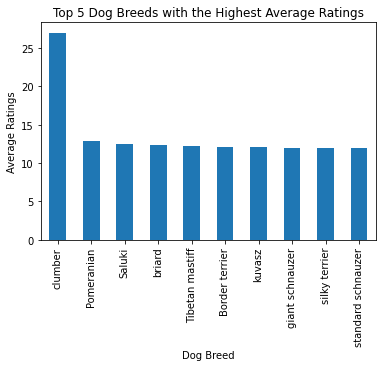

In [97]:
top_breed_ratings.plot(kind='bar')
plt.title('Top 5 Dog Breeds with the Highest Average Ratings')
plt.xlabel('Dog Breed')
plt.ylabel('Average Ratings')

### Bar graph showing top 10 breeds with the highest average ratings

Text(0, 0.5, 'Average Ratings')

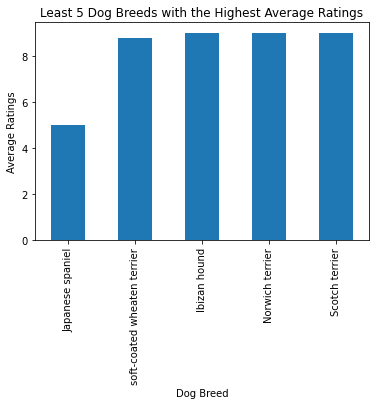

In [98]:
Low_breed_ratings.head(5).plot(kind='bar')
plt.title('Least 5 Dog Breeds with the Highest Average Ratings')
plt.xlabel('Dog Breed')
plt.ylabel('Average Ratings')

### Bar graph showing least 10 breeds with the lowest average ratings

Text(0, 0.5, 'Average Ratings')

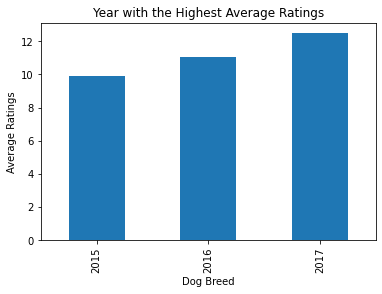

In [99]:
Year_ratings.plot(kind='bar')
plt.title('Year with the Highest Average Ratings')
plt.xlabel('Dog Breed')
plt.ylabel('Average Ratings')

### Bar graph showing average ratings for each year. We can see 2017 has the highest number of ratings among all years

Text(0, 0.5, '')

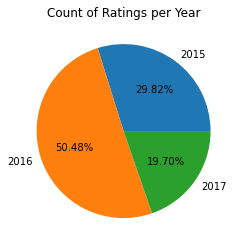

In [100]:
# Year with the most number of ratings

combined_df.groupby('Year').count()['rating_numerator'].plot(kind='pie', autopct='%.2f%%')
plt.title('Count of Ratings per Year')
plt.ylabel('')

### Pie chart showing number of ratings per year, here we can see that 2016 saw the highest number of ratings with over 50% followed by 2015 with 29.82% and 2017 having the least with 19.70%